In [1]:
import scipy
import datetime
import functools
import numpy as np
import pandas as pd
import tensorflow as tf

import matplotlib.pyplot as plt

from scipy.stats import multivariate_normal as norm
%matplotlib inline 

tfd = tf.contrib.distributions
tfn = tf.contrib.rnn
tfl = tf.linalg
dynrnn = tf.nn.dynamic_rnn

Instructions for updating:
Use the retry module or similar alternatives.


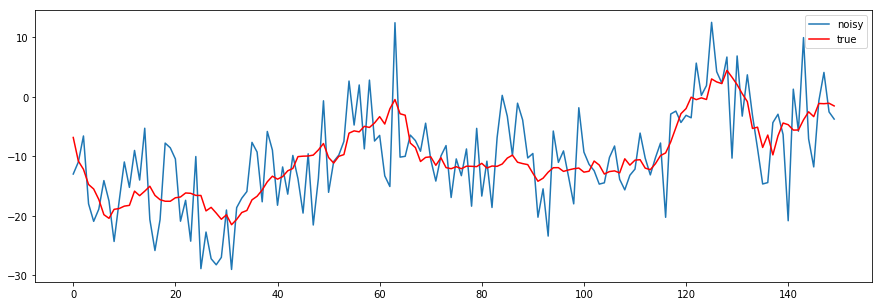

In [189]:
np.random.seed(0)
n_hidden = 140; seq_length = 300; training_size = 1000
h = np.zeros((training_size, seq_length + 1, n_hidden)); 
h[:, 0, :] = norm.rvs(mean=None, cov=np.eye(n_hidden), size=training_size)
y = np.zeros((training_size, seq_length + 1, 1)); y[:, 0] = np.zeros((training_size, 1))
sigma_c = 5.3
sigma_b = 1.

A = 0.08 * np.random.randn(n_hidden, n_hidden)
R = scipy.linalg.expm(A - A.T)
B = 0.2 * np.random.rand(1, n_hidden)
b = 0.1 * np.random.randn(n_hidden, 1)
c = 0.1 * np.random.randn(n_hidden, 1)
bias_h = np.random.rand(1, n_hidden)
d = 0.01 * np.random.rand(n_hidden, 1)

for i in range(1, seq_length + 1):
    h[:, i, :] = np.tanh(np.dot(h[:, i-1, :], R) + np.dot(y[:, i-1], B)) + 0.7 * h[:, i-1, :] + bias_h
    y[:, i] = (3 * np.dot(h[:, i, :], b) + 4 * np.tanh(np.dot(h[:, i, :], c)) 
               + 3 * softplus(np.tanh(np.dot(h[:, i, :], d)) - 2) * np.random.randn(training_size, 1))

y = y[:, 1:]
fig, ax = plt.subplots(1,1,figsize=(15, 5))
y_tilde = (y + sigma_c * np.random.randn(training_size, seq_length, 1))

seq_length = 150
training_data = y_tilde[:training_size]
testing_data = y_tilde[training_size:]

plt.plot(y_tilde[0, :seq_length], label='noisy');
plt.plot(y[0, :seq_length], 'r', label='true');
plt.legend();

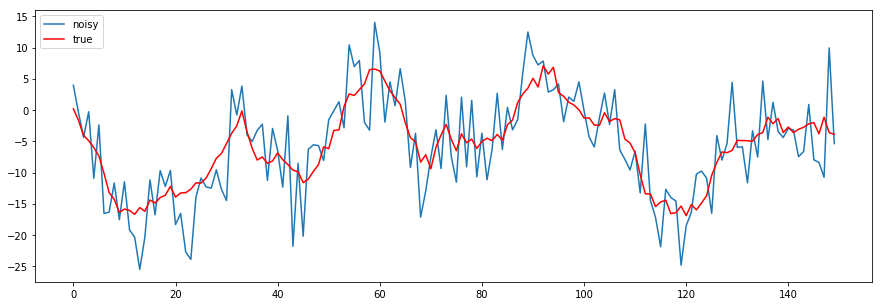

In [197]:
idx = np.random.randint(0, 100)
fig, ax = plt.subplots(1,1,figsize=(15, 5))
plt.plot(y_tilde[idx, :seq_length], label='noisy');
plt.plot(y[idx, :seq_length], 'r', label='true');
plt.legend();

In [73]:
def doublewrap(function):
    """
    A decorator decorator, allowing to use the decorator to be used without
    parentheses if not arguments are provided. All arguments must be optional.
    """
    @functools.wraps(function)
    def decorator(*args, **kwargs):
        if len(args) == 1 and len(kwargs) == 0 and callable(args[0]):
            return function(args[0])
        else:
            return lambda wrapee: function(wrapee, *args, **kwargs)
    return decorator


@doublewrap
def define_scope(function, scope=None, *args, **kwargs):
    """
    A decorator for functions that define TensorFlow operations. The wrapped
    function will only be executed once. Subsequent calls to it will directly
    return the result so that operations are added to the graph only once.
    The operations added by the function live within a tf.variable_scope(). If
    this decorator is used with arguments, they will be forwarded to the
    variable scope. The scope name defaults to the name of the wrapped
    function.
    """
    attribute = '_cache_' + function.__name__
    name = scope or function.__name__
    @property
    @functools.wraps(function)
    def decorator(self):
        if not hasattr(self, attribute):
            with tf.variable_scope(name, *args, **kwargs):
                setattr(self, attribute, function(self))
        return getattr(self, attribute)
    return decorator

In [75]:
class GaussianCell(tf.contrib.rnn.RNNCell):
    
    def __init__(self, cell, event_size, std=None, reuse=None):       
        super(GaussianCell, self).__init__(_reuse=reuse)
        self._cell = cell
        self._event_size = event_size
        if std is not None:
            self._std = std[None, None]
        else:
            self._layer_1 = tf.layers.Dense(100, tf.nn.relu)
            self._layer_sigma = tf.layers.Dense(self._event_size, tf.nn.softplus)

    @property
    def state_size(self):
        return self._cell.state_size

    @property
    def output_size(self):
        return (self._event_size, self._event_size)

    def call(self, inputs, state):
        hidden, state = self._cell(inputs, state)
        mean = tf.layers.dense(hidden, self._event_size)
        try: 
            std = self._layer_sigma(self._layer_1(hidden)) + 1e-5
            return (mean, std), state
        except AttributeError:
            n_samples = mean.shape[0]
            return (mean, tf.tile(self._std, (n_samples, self._event_size))), state
    
class SamplingCell(tf.contrib.rnn.RNNCell):
    """
    RNN cell that produce a sequence in autoregressive mode by sampling at
    each step
    """

    def __init__(self, cell, output_size, reuse=None):
        super(SamplingCell, self).__init__(_reuse=reuse)
        self._cell = cell
        self._output_size = output_size

    @property
    def state_size(self):
        return (self._cell.state_size, self._output_size)

    @property
    def output_size(self):
        return (self._output_size, self._output_size, self._output_size)

    def call(self, _ , state_and_sample):
        (state, sample) = state_and_sample
        (mean, std), state = self._cell(sample, state)
        sample = tfd.MultivariateNormalDiag(mean, std).sample()
        return (mean, std, sample), (state, sample)
    
class BeamSamplingCell(tf.contrib.rnn.RNNCell):
    """
    RNN cell that produce a Beam Search sequence in autoregressive mode by sampling and pruning
    at every step
    """
    
    def __init__(self, cell, output_size, branch_width, reuse=None):
        super(BeamSamplingCell, self).__init__(_reuse=reuse)
        self._cell = cell
        self._output_size = output_size
        self._branch_width = branch_width
        
    @property
    def state_size(self):
        (self._cell.state_size, self._output_size, 1)
        
    @property
    def output_size(self):
        return (self._output_size, self._output_size)
    
    def call(self, _, state_and_sample_and_prob):
        (state, sample, probs) = state_and_sample_and_prob
        (mean, std), state = self._cell(sample, state)
        dist = tfd.MultivariateNormalDiag(mean, std)
        sample = dist.sample((self._branch_width))
        new_probs = dist.log_prob(sample)
        new_probs = tf.reshape(new_probs, [-1])
        probs = tf.reshape(tf.tile(probs[None, ..., 0], [self._branch_width, 1]), [-1])
        best_probs, best_idx = tf.nn.top_k(new_probs + probs, k=self._branch_width)
        best_samples = tf.gather(tf.reshape(sample, [-1, self._output_size]), best_idx)
        
        return (mean, best_samples), (state, best_samples, best_probs[..., None])

In [80]:
class RobustARGenerator(object):
    """
    Model to test
    """
    def __init__(self, data, n_hidden, n_samples, seq_length, batch_size, alpha=None, beta=None):
        self._data = data                                            # B x T x D
        self._B = batch_size                                         # B - batch size
        self._T = seq_length                                         # T - number of time steps
        self._D = 1                                                  # D - dimensionality of each time step
        self._H = n_hidden                                           # H - dimensionality of RNN hidden states
        self._Sz = n_samples                                         # Sz - number of samples from the posterior
        self._Z = 20                                                 # Z - dimensionality of the global latent z
        self._alpha0 = alpha                                         # parameter of inverse gamma prior (optional)
        self._beta0 = beta                                           # parameter of inverse gamma prior (optional)

        self.initialise_variables                                    # 
        
        self.q_z = self.make_posterior_z                             # posterior q(z|x)
        self.p_y = self.make_transitional                            # prior p(y|z) under q(z)
        self.q_phi_y = self.make_forward_posterior_y                 # forward posterior q(y|y_bar)
        self.q_phi_z = self.make_forward_posterior_z                 # forward posterior q(z|y_bar)
        self.p_y_kl_forward, self.p_y_bar = self.make_rnn_forward    # prior p(y|z) and forward "prior" p(y_bar|y, z)
                                                                     # under q(z|y_bar) and q(y|y_bar)
        self.compute_elbo
        self.optimise

        self.compute_elbo_forward
        self.forward_E_step
        self.forward_M_step

    @define_scope
    def initialise_variables(self):
        # Initialises all variables and RNN cells
        self._cell = tfn.GRUBlockCell(self._H)
        self._gauss_cell = GaussianCell(self._cell, self._D)
        self._sampling_cell = SamplingCell(self._gauss_cell, self._D)
        self._layer = tf.layers.Dense(self._H, tf.nn.relu)
        self._post_cell_z = tfn.GRUBlockCell(self._H)

        self._most_likely_pred = tf.get_variable(shape=(self._B, 30, self._D), name='most_likely_forward',
                                                 initializer=tf.constant_initializer(0))

        self._post_forward_cell_y = tfn.GRUBlockCell(self._H)
        self._gauss_forward_cell_y = GaussianCell(self._post_forward_cell_y, self._D)
        self._post_forward_cell_z = tfn.GRUBlockCell(self._H)

        self._optimiser = tf.train.AdamOptimizer(0.001)

    @define_scope
    def make_posterior_z(self):
        # Computes the posterior distribution q(z|x)
        _, h = dynrnn(self._post_cell_z, self._data, dtype=tf.float32)
        means = tf.layers.dense(h, self._Z)
        stds = tf.layers.dense(h, self._Z, tf.nn.softplus) + 1e-5
        posterior_z = tfd.MultivariateNormalDiag(means, stds)
        return posterior_z

    @define_scope
    def make_kl_z(self):
        # Computes the KL divergence from p(z) to q(z|x)
        p = tfd.MultivariateNormalDiag(np.zeros(self._Z, dtype=np.float32), np.ones(self._Z, dtype=np.float32))
        return tf.reduce_sum(tfd.kl_divergence(self.q_z, p))

    @define_scope
    def make_transitional(self):
        # Computes the prior p(y|z) = q(y|z) under q(z|x) by passing z through dense layer, then
        # using this as initial state, outputs the distn of p(y_t|y_{<t},z) at each t
        self._code_z = self.q_z.sample((self._Sz))
        hidden = self._layer(tf.reshape(self._code_z, [-1, self._Z]))                         # (Sz * B) x H
        state_and_sample = (hidden, tf.zeros((self._B * self._Sz, self._D)))
        inputs = tf.zeros((self._B * self._Sz, self._T, self._D))
        (means, stds, self._code_y), _ = dynrnn(self._sampling_cell, initial_state=state_and_sample, inputs=inputs)
        means = tf.identity(means, name='means')
        stds = tf.identity(stds, name='stds')
        return tfd.MultivariateNormalDiag(means, stds)

    @define_scope
    def make_reconstruction(self):
        # Computes the expected reconstruction log p(x|y) under q(y,z|x)
        if not (self._alpha0 is not None and self._beta0 is not None):
            self._gen_std = tf.nn.softplus(tf.get_variable(shape=(), name='generative_std', 
                                                           initializer=tf.constant_initializer(1))) + 1e-5
        else:
            alpha1 = alpha0
            beta1 = beta0
        gen_prob = tfd.MultivariateNormalDiag(self._code_y, scale_identity_multiplier=self._gen_std)
        data = tf.reshape(tf.tile(self._data[None, ...], (self._Sz, 1, 1, 1)), [-1, self._T, self._D])
        return tf.reduce_sum(gen_prob.log_prob(data))/self._Sz

    @define_scope
    def compute_elbo(self):
        # Computes the ELBO used for training
        kl_z = self.make_kl_z
        reconstruction = self.make_reconstruction
        loss = reconstruction - kl_z
        return loss, kl_z, reconstruction

    @define_scope
    def optimise(self):
        # Optimses the ELBO function
        vars_modelling = [v for v in tf.trainable_variables() if v.name.startswith('make_posterior') 
                          or v.name.startswith('make_transitional') or v.name.startswith('compute_elbo')]
        gradients, variables = zip(*self._optimiser.compute_gradients(-self.compute_elbo[0], var_list=vars_modelling))
        gradients, _ = tf.clip_by_global_norm(gradients, 5.0)
        return self._optimiser.apply_gradients(zip(gradients, variables))

    @define_scope
    def make_forward_posterior_y(self):
        # Computes the forward variational distribution q_psi(y|x, y_bar)

        # for q(y_{1:T}|x_{1:T},y_{T+1:T+K}), pass y_{T+1:T+K} through rnn and use
        # final hidden state for input to new rnn taking x_{1:T} as input and outputting
        # means and stds of q(y_{1:T}) - not necessarily smart implementation, seq2seq should
        # be better but need to figure out how to do that
        _, h_qy = dynrnn(self._post_forward_cell_y, self._most_likely_pred, dtype=tf.float32)
        (means_qy, stds_qy), _ = dynrnn(self._gauss_forward_cell_y, inputs=self._data, initial_state=h_qy)
        return tfd.MultivariateNormalDiag(means_qy, stds_qy)
        
    @define_scope
    def make_forward_posterior_z(self):
        # Computes the forward variational distribution q_psi(z|x, y_bar)
        
        # concatenate x_{1:T}, y_{1:T+K} for q(z|...)
        # sample from posterior_qy
        code_qy = self.q_phi_y.sample()
        concat_q_z = tf.concat([code_qy, self._most_likely_pred], 1)
        _, h_qz = dynrnn(self._post_forward_cell_z, concat_q_z, dtype=tf.float32)
        means_qz = tf.layers.dense(h_qz, self._Z)
        stds_qz = tf.layers.dense(h_qz, self._Z, tf.nn.softplus) + 1e-5
        return tfd.MultivariateNormalDiag(means_qz, stds_qz)

    @define_scope
    def make_rnn_forward(self):
        # Computes p(y|z) and p(y_bar|y, z) under q_psi(z) and q_psi(y) to be used in the KL divergence and 
        # reconstruction term of the new ELBO
        self._code_z_forw = tf.reshape(self.q_phi_z.sample((self._Sz)), [-1, self._Z])
        self._code_y_forw = tf.reshape(self.q_phi_y.sample((self._Sz)), [-1, self._T, self._D])
        
        inputs = tf.concat([tf.zeros((self._Sz * self._B, 1, self._D)), self._code_y_forw[:, :-1]], 1)
        (means_y, stds_y), hT = dynrnn(self._gauss_cell, inputs, initial_state=self._layer(self._code_z_forw))
        p_y = tfd.MultivariateNormalDiag(tf.reshape(means_y, [self._Sz, self._B, self._T, self._D]), 
                                         tf.reshape(stds_y, [self._Sz, self._B, self._T, self._D]))
        
        forward = tf.reshape(tf.tile(self._most_likely_pred[None, ...], [self._Sz, 1, 1, 1]), [-1, 30, self._D])
        new_inputs = tf.concat([self._code_y_forw[:, -1:], forward[:, :-1]], 1)
        (means_forw, stds_forw), _ = dynrnn(self._gauss_cell, inputs=new_inputs, initial_state=hT)
        p_y_bar = tfd.MultivariateNormalDiag(means_forw, stds_forw)
        
        return p_y, p_y_bar

    @define_scope
    def make_forward_kl(self):
        p_z = tfd.MultivariateNormalDiag(np.zeros(self._Z, dtype=np.float32), np.ones(self._Z, dtype=np.float32))
        kl_z = tfd.kl_divergence(self.q_phi_z, p_z)
        
        kl_y = tfd.kl_divergence(self.q_phi_y, self.p_y_kl_forward)

        return tf.reduce_sum(kl_z), tf.reduce_sum(kl_y)/self._Sz

    @define_scope
    def make_forward_reconstruction(self):
        # expectation of log p(y_t|y_<t,z) for T+1:T+K
        forward = tf.reshape(tf.tile(self._most_likely_pred[None, ...], [self._Sz, 1, 1, 1]), [-1, 30, self._D])       
        exp_py  = tf.reduce_sum(self.p_y_bar.log_prob(forward))/self._Sz
        
        # expectation of log p(x_t|y_t) for 1:T
        p_x = tfd.MultivariateNormalDiag(self._code_y_forw, scale_identity_multiplier=self._gen_std)
        data = tf.reshape(tf.tile(self._data[None, ...], (self._Sz, 1, 1, 1)), [-1, self._T, self._D])
        exp_px  = tf.reduce_sum(p_x.log_prob(data))/self._Sz

        return exp_px, exp_py

    @define_scope
    def compute_elbo_forward(self):
        # KL terms
        (kl_z, kl_y) = self.make_forward_kl
        # expectation of log p(y_t|y_<t,z) for T+1:T+K
        # and expectation of log p(x_t|y_t) for 1:T
        reconstruction_x, forward_reconstruction_y = self.make_forward_reconstruction

        return forward_reconstruction_y + reconstruction_x - kl_z - kl_y

    @define_scope
    def forward_E_step(self):
        var_e = [v for v in tf.trainable_variables() if 'make_forward_posterior' in v.name]
        gradients, variables = zip(*self._optimiser.compute_gradients(-self.compute_elbo_forward, var_list=var_e))
        gradients, _ = tf.clip_by_global_norm(gradients, 5.0)
        return self._optimiser.apply_gradients(zip(gradients, variables))

    @define_scope
    def forward_M_step(self):
        var_m = [v for v in tf.trainable_variables() if 'most_likely_forward' in v.name]
        gradients, variables = zip(*self._optimiser.compute_gradients(-self.compute_elbo_forward, var_list=var_m))
        gradients, _ = tf.clip_by_global_norm(gradients, 5.0)
        return self._optimiser.apply_gradients(zip(gradients, variables))

In [85]:
tf.reset_default_graph()

seq_length = 100; n_samples = 500; batch_size = 20

x_ = tf.placeholder(tf.float32, [batch_size, seq_length, 1])

gen_model = RobustARGenerator(x_, n_hidden=30, n_samples=n_samples, seq_length=seq_length, batch_size=batch_size)

sess = tf.Session()
saver = tf.train.Saver([v for v in tf.global_variables() if 'forward' not in v.name])

try:
    saver.restore(sess, "./robust_model1.ckpt")
    sess.run(tf.variables_initializer([v for v in tf.global_variables() if 'forward' in v.name]))
    
except Exception:
    
    sess.run(tf.global_variables_initializer())
    elbos = []; kls_z = []; llks = []; test_elbos = []
    
    for i in range(50001):
        idx = np.random.randint(0, training_size, batch_size)
        batch = training_data[idx, :seq_length]

        elbo, kl_z, llk = sess.run(gen_model.compute_elbo, {x_: batch})
        elbos.append(elbo); kls_z.append(kl_z); llks.append(llk)
        
        if i % 5000 == 0:
            print('Iteration:', i, 'ELBO:', elbo, 'KL (z):', kl_z, 'Reconstruction:', llk)

        sess.run(gen_model.optimise, {x_: batch})
        
    saver.save(sess, './robust_model.ckpt')

INFO:tensorflow:Restoring parameters from ./robust_model1.ckpt
Iteration: 0 ELBO: -162069.44 KL (z): 317.25476 Reconstruction: -161752.19
Iteration: 5000 ELBO: -10032.487 KL (z): 151.3407 Reconstruction: -9881.146


KeyboardInterrupt: 

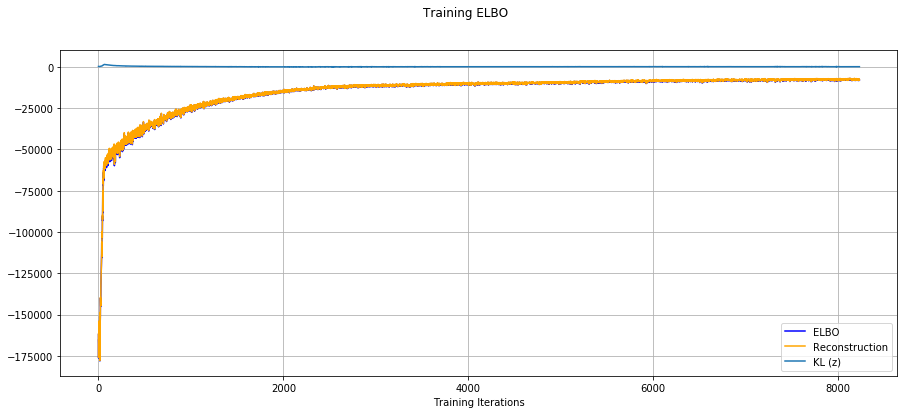

In [86]:
# New plot
fig, ax = plt.subplots(1, 1, figsize=(15,6))
plt.plot(elbos, 'b', label='ELBO')
plt.plot(llks, 'orange', label='Reconstruction')
plt.plot(kls_z, label='KL (z)')
plt.suptitle('Training ELBO')
ax.set_xlabel('Training Iterations')
plt.grid("on")
plt.legend();

In [88]:
# np.random.seed(0)
idx = np.random.randint(0, training_size, batch_size)
batch = testing_data[idx, ...]

trans_means_op = tf.get_default_graph().get_tensor_by_name('make_transitional/means:0')
means = sess.run(trans_means_op, {x_: batch})
latents = sess.run(gen_model._code_y, {x_: batch})

# np.random.seed(0)
i = np.random.randint(0, batch_size)
plt.subplots(1,1,figsize=(15,6))
plt.plot(batch[i, :], 'b', label='Noisy Sequence')
plt.plot(np.mean(np.reshape(means, (n_samples, batch_size, seq_length, 1)), 0)[i], 'r-', label='Posterior Means')
plt.plot(np.reshape(latents, (n_samples, batch_size, seq_length))[1, i] , 'g', label='Posterior Sample')
plt.plot(np.reshape(latents, (n_samples, batch_size, seq_length))[0, i] , 'g')
plt.plot(np.reshape(latents, (n_samples, batch_size, seq_length))[2, i] , 'g')
plt.plot([], [])
plt.plot(y[training_size + idx[i], 70:70+seq_length], label='Clean Signal')
plt.suptitle('Modelling (Robust Seq-VAE)')
plt.legend();
plt.savefig('robust-seq-vae-modelling.pdf', bbox_inches='tight')

IndexError: index 196 is out of bounds for axis 0 with size 0

In [51]:
forw_seq = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, 'make_forward_parameters/best_forward_sequence:0')[0]
assign_op = forw_seq.assign(np.tile(np.mean(batch, 1)[:1], (30, 1)))

sess.run(assign_op);

elbos_forward = [];

for i in range(15001):   
    elbo_forward = sess.run(gen_model.compute_elbo_forward, {x_: batch})
    sess.run(gen_model.forward_E_step, {x_: batch})
    sess.run(gen_model.forward_M_step, {x_: batch})
    
    elbos_forward.append(elbo_forward)
    
    if i % 5000 == 0:
        print('Iteration:', i, 'ELBO Forward:', elbo_forward)

Iteration: 0 ELBO Forward: -50693100000000.0


KeyboardInterrupt: 

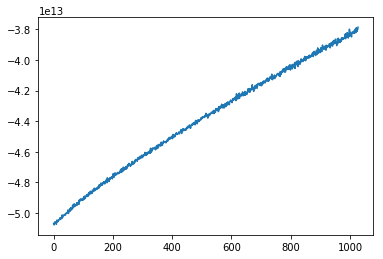

In [52]:
plt.plot(elbos_forward)

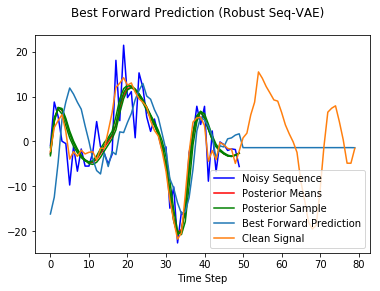

In [55]:
# i = 0
plt.plot(batch[i, :], 'b', label='Noisy Sequence')
plt.plot(np.mean(np.reshape(means, (n_samples, batch_size, seq_length, 1)), 0)[i], 'r-', label='Posterior Means')
plt.plot(np.reshape(latents, (n_samples, batch_size, seq_length))[1, i] , 'g', label='Posterior Sample')
plt.plot(np.reshape(latents, (n_samples, batch_size, seq_length))[0, i] , 'g')
plt.plot(np.reshape(latents, (n_samples, batch_size, seq_length))[2, i] , 'g')

continuation = sess.run(gen_model.make_forward_parameters, {x_: batch})
plt.plot(np.concatenate([y[idx[i], 70:70+seq_length], continuation], 0), label='Best Forward Prediction')
plt.plot(y[training_size + idx[i], 70:70+seq_length+30], label='Clean Signal')
plt.legend()
plt.xlabel('Time Step')
plt.suptitle("Best Forward Prediction (Robust Seq-VAE)");
# plt.savefig('robust-seq-vae-prediction.pdf', bbox_inches='tight')